In [295]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Saved references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Created my session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [17]:
# Get columns
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
# Get columns
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [ ]:
# Designed a query to retrieve the last 12 months of precipitation data and plot the results
# Calculateed the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("Last Date:", last_date)
query_date = dt.date(2017, 8 ,23) - dt.timedelta(days=365)
print("Query Date: ", query_date)
# Performed a query to retrieve the data and precipitation scores
last_twelve = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date.desc()).all()
# Saved the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_twelve[:], columns=['Date', 'Prcp'])\
    .replace(to_replace='None', value=np.nan).dropna()
df.set_index('Date', inplace=True)
df.head(10)
# Sorted the dataframe by date
df = df.sort_values('Date')
df.head()
# Used Pandas Plotting with Matplotlib to plot the data
prcp = df.reset_index()["Prcp"]
df.plot(kind="bar", width=0.5, figsize=(20, 15), xticks = x_pos)
plt.show()

![precipitation](Images/precipitation.png)

In [177]:
# Used Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [178]:
# Designed a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [179]:
# List the most active stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [180]:
# Using the station id from the previous query, calculated the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Last Date for Max_Temp_Observed: ('2017-08-18',)
Query Date:  2016-08-18


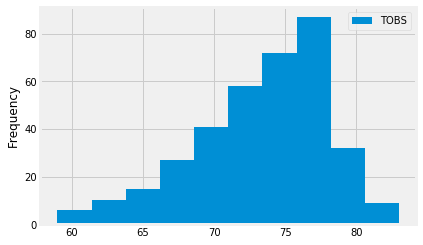

In [287]:
# Chose the station with the highest number of temperature observations.
max_tobs_last_date = session.query(Measurement.date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()
print("Last Date for Max_Temp_Observed:", max_tobs_last_date)
query_date = dt.date(2017, 8 ,18) - dt.timedelta(days=365)
print("Query Date: ", query_date)
# Queried the last 12 months of temperature observation data for this station and plot the results as a histogram
last_twelve_max_tobs = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-08-18').\
    order_by(Measurement.date.desc()).all()
# Saved the query results as a Pandas DataFrame and set the index to the date column
max_tobs_df = pd.DataFrame(last_twelve_max_tobs[:], columns=['Date', 'TOBS'])\
    .replace(to_replace='None', value=np.nan).dropna()
max_tobs_df.head(10)
# Sorted the dataframe by date
max_tobs_df = max_tobs_df.sort_values('Date').set_index('Date')
max_tobs_df.head()
max_tobs_df.plot.hist()

In [286]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [17]:
# Used previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for the trip using the previous year's data for those same dates.
print(calc_temps('2016-02-28', '2016-03-05'))

62.0 68.36585365853658 74.0


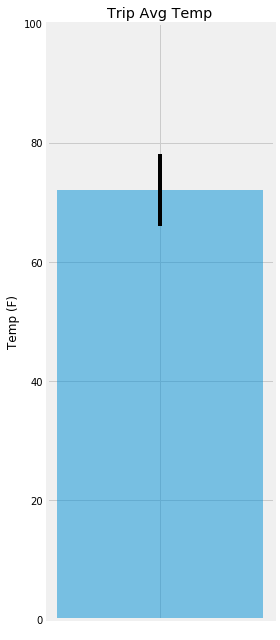

In [288]:
# Plotted the results from the previous query as a bar chart. 
fig, ax = plt.subplots(figsize=(4, 9))
x_pos = [" "]
mini,avg,maxi = calc_temps('2017-02-28', '2017-03-05')[0]
ax.bar(x_pos, avg, yerr=max(mini-avg,maxi-avg), alpha=0.5, ecolor='black', width = 0.35)
ax.set_ylabel('Temp (F)')
ax.set_ylim(0,100)
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

# Show
plt.tight_layout()
plt.show()

In [289]:
# Calculated the total amount of rainfall per weather station for my trip dates using the previous year's matching dates.
# Sort query in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station,Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date >= '2017-02-28').\
    filter(Measurement.date >= '2017-03-05').\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)]

## More Analysis

In [291]:
# Function that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("06-01")

[(64.0, 74.6140350877193, 81.0)]

In [293]:
def ttestvalues(date):
    sel = [Measurement.tobs]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
one = ttestvalues("06-01")
two = ttestvalues("12-01")

In [296]:
stats.ttest_ind(one, two, equal_var=False)

Ttest_indResult(statistic=array([3.91836547]), pvalue=array([0.00016079]))

In [270]:
# Calculated the daily normals for my trip
# pushed each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2017-02-28'
end = '2017-03-05'
# Use the start and end date to create a range of dates
startdate = dt.datetime.strptime(start, "%Y-%m-%d")
enddate = dt.datetime.strptime(end, "%Y-%m-%d")
date_generated = [startdate + dt.timedelta(days=x) for x in range(0, (enddate-startdate).days)]

new_date = []
for date in date_generated:
    print(date.strftime("%Y-%m-%d"))
    new_date.append(date.strftime("%Y-%m-%d"))

# Strip off the year and save a list of %m-%d strings
stripped_date = [date.strftime("%m-%d") for date in date_generated]
# Loop through the list of %m-%d strings and calculate the normals for each date
date_query = [daily_normals(date)[0] for date in stripped_date]
date_query

2017-02-28
2017-03-01
2017-03-02
2017-03-03
2017-03-04


[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0)]

In [271]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
query_df = pd.DataFrame(date_query[:], columns=['tmin', 'tavg', 'tmax'], index=new_date)
query_df.index.name = "date"
query_df

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0


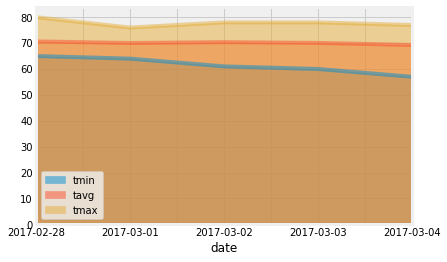

In [272]:
# Plotted the daily normals as an area plot with `stacked=False`
query_df.plot(kind='area', stacked=False)